In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

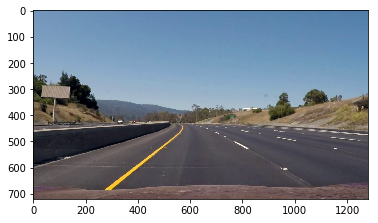

In [3]:
# Read in an image
image = mpimg.imread('test_image.jpg')
plt.imshow(image)
plt.show()

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # 1) Convert to grayscale
    
    # Take the derivative in x
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max        
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

In [5]:
def color_threshold(img, thresh=(0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    s_channel = hls[:,:,2]
    
    color_binary = np.zeros_like(s_channel)
    color_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return color_binary

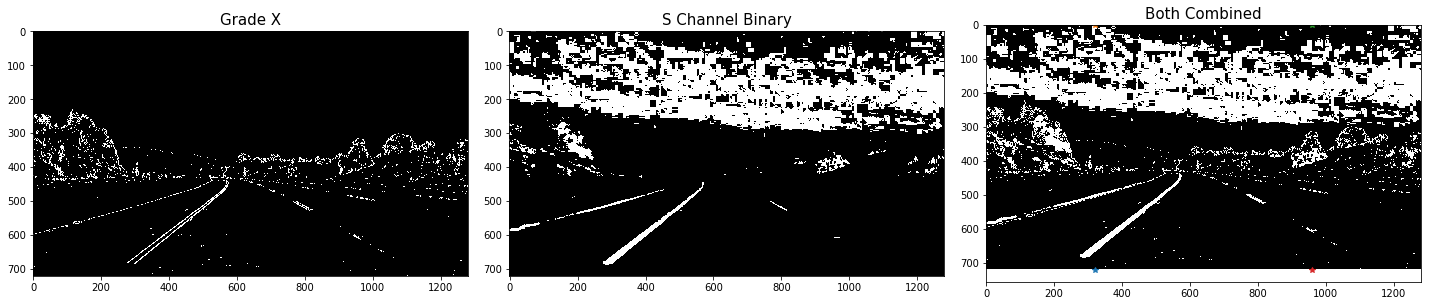

In [6]:
gradex = abs_sobel_thresh(image, orient='x', sobel_kernel=9, thresh=(20, 100))
channel_binary = color_threshold(image, thresh=(90, 255))
combined = np.zeros_like(channel_binary)
combined[(gradex == 1) | (channel_binary == 1)] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
f.tight_layout()
ax1.imshow(gradex, cmap='gray')
ax1.set_title('Grade X', fontsize=15)
ax2.imshow(channel_binary, cmap='gray')
ax2.set_title('S Channel Binary', fontsize=15)
ax3.imshow(combined, cmap='gray')
#ax3.plot(180, combined.shape[0], '*')
#ax3.plot(575, 460, '*')
#ax3.plot(705, 460, '*')
#ax3.plot(1150, combined.shape[0], '*')
ax3.plot(320, combined.shape[0], '*')
ax3.plot(320, 0, '*')
ax3.plot(960, 0, '*')
ax3.plot(960, combined.shape[0], '*')
ax3.set_title('Both Combined', fontsize=15)
plt.show()

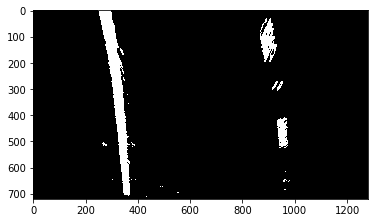

In [22]:
# Perspective Transform
src = np.float32([[180, combined.shape[0]], [575, 460], 
                      [705, 460], [1150, combined.shape[0]]])
dst = np.float32([[320, combined.shape[0]], [320, 0], 
                      [960, 0], [960, combined.shape[0]]])
#dst = np.float32([[100,680],[150,200],[620,200],[1120,680]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
binary_warped = cv2.warpPerspective(combined, M, (combined.shape[1], combined.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap='gray')
plt.show()

C:\Users\admin\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


(1280,)


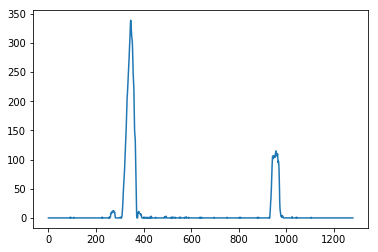

In [9]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
print(histogram.shape)
plt.plot(histogram)
plt.show()

In [10]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 # binary_wraped shape - (720, 1280)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines

midpoint = np.int(histogram.shape[0]/2)  # 640

leftx_base = np.argmax(histogram[:midpoint])  # 346 Index

rightx_base = np.argmax(histogram[midpoint:]) + midpoint  # 956 Index

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)  # 720/9 = 80
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):  # [0, 1, 2, .... , 8]
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height  # 720 - (1)*80 = 640
    win_y_high = binary_warped.shape[0] - window*window_height  # 720 - 0 = 720
    win_xleft_low = leftx_current - margin  # 346 - 100 = 246 Index
    win_xleft_high = leftx_current + margin  # 346 + 100 = 446 Index
    win_xright_low = rightx_current - margin  # 956 - 100 = 856 Index
    win_xright_high = rightx_current + margin  # 956 + 100 = 1056 Index
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)  #(246, 640), (446, 720)
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:  # 1754 > 50
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

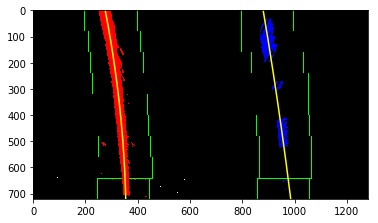

In [11]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [12]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

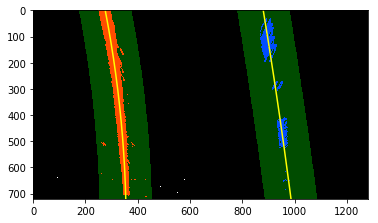

In [13]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

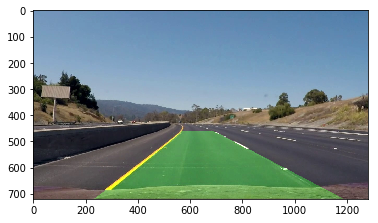

In [25]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()